In [1]:
import pandas as pd
import json
from collections import defaultdict
import os 

In [15]:
# словарь для выдуманных меток и их соответствий реальным
lable_mapping_1 = {
    'Philosophy': 'Humanities',
    'Economics': 'Social Sciences',
    'Economics and Business': 'Social Sciences',
    'Economics and business': 'Social Sciences',
    'Economics and Finance': 'Social Sciences',
    'Economics & Business': 'Social Sciences',
    'Business and Management': 'Social Sciences',
    'Business and Economics': 'Social Sciences',
    'Business': 'Social Sciences',
    #'Agricultural Sciences': "Social Sciences",
    'Law': 'Social Sciences',
    'Law and Legal Studies': 'Social Sciences',
    'Finance': 'Social Sciences',
    'Education and Pedagogy': 'Social Sciences',
    'Education': 'Social Sciences',
    'Educational Sciences': 'Social Sciences',
    'Educational sciences': 'Social Sciences',
    'Psychological and Pedagogical Sciences': 'Social Sciences',
    'Urban Planning': 'Social Sciences',
    'Urban Planning and Environmental Management': 'Social Sciences',
    'Legal and Jurisprudence': 'Social Sciences',
    'Law and Jurisprudence': 'Social Sciences',
    'Legal and Political Sciences': 'Social Sciences',
    'Psychological Sciences': 'Social Sciences',
    'Psychology': 'Social Sciences',
    'Political Science': 'Social Sciences',
    'Political science': 'Social Sciences',
    'International Relations': 'Social Sciences',
    'Media and Communication': 'Social Sciences',
    'Environmental and Health Sciences': 'Social Sciences',
    'History and archaeology': 'Humanities',
    'History and Archaeology': 'Humanities',
    'History': 'Humanities',
    'Literature': 'Humanities',
    'Earth and related environmental sciences': 'Social Sciences',
    'Environmental and Natural Sciences': 'Social Sciences',
    'Environmental Sciences': 'Social Sciences',
    'Environmental Engineering': 'Engineering',
    'Natural Sciences': 'IT and Natural Sciences',
    'Physical Sciences': 'Medical and Health Sciences'
}

lable_mapping_2 = {}

right_labels_dict = {
    'Engineering': 'Engineering and Technology',
    'IT and Natural Sciences': 'Natural Sciences',
}


In [21]:
TEST_ROOT = 'data/test/'
TRAIN_ROOT = 'data/train/'

def right_labels(df, right_labels_dict=right_labels_dict):
    '''Функция для замены меток на правильные.'''
    df['first_OECD_pred'] = df['first_OECD_pred'].replace(right_labels_dict)
    #df['OECD_pred'] = df['OECD_pred'].replace(right_labels_dict)
    return df

def label_determination(predictions, oecd_labels, lable_mapping):
    '''Функция для выбора метки на основании нескольких предсказаний.'''
    label = None
    labels_counter = defaultdict(int)

    for pred in predictions:
        labels_counter[pred['class']] += 1

    # список меток и их количества (label, count), отсортированный по убыванию     
    sorted_labels = sorted(labels_counter.items(), key=lambda x: x[1], reverse=True)

    if sorted_labels[0][1] >= 2 and sorted_labels[0][0] in oecd_labels:
        label = sorted_labels[0][0]
    elif sorted_labels[0][1] >= 2 and sorted_labels[0][0] in lable_mapping.keys():
        mapped_label = lable_mapping[sorted_labels[0][0]]
        if mapped_label in oecd_labels:
            label = mapped_label
    elif sorted_labels[0][0] == 'Agricultural Sciences':
        if len(sorted_labels) > 1:
            label = sorted_labels[0][0]
        else:
            label = 'Social Sciences'

    return label, sorted_labels



def prediction_to_df(file_name, test=True, group=False):
    '''Функция для преобразования файла с предсказаниями в DataFrame.'''
    if group:
        with open(f'data/zeroshot_topics_2.json', "r") as f:
            lable_mapping = lable_mapping_2
            oecd_labels = list(json.load(f)[file_name[-1]].values())
    else:
        with open(f'data/zeroshot_topics_1.json', "r") as f:
            lable_mapping = lable_mapping_1
            oecd_labels = list(json.load(f).values())

    data_root = TEST_ROOT if test else TRAIN_ROOT
    file_path = os.path.join(data_root, f'pred_{file_name}.jsonl')

    with open(file_path, 'r') as f:
        articles = []
        for line in f:
            article = json.loads(line)
            if len(article['predicted_classes']) < 3 and article['predicted_classes'][0]['class'] in oecd_labels:
                if group:
                    article['OECD_pred'] =  article['predicted_classes'][0]['class']
                else:
                    article['first_OECD_pred'] =  article['predicted_classes'][0]['class']
            else:
                if group:
                    article['OECD_pred'], article['sorted_preds'] =  label_determination(article['predicted_classes'], oecd_labels, lable_mapping)
                else:
                    article['first_OECD_pred'], article['first_sorted_preds'] =  label_determination(article['predicted_classes'], oecd_labels, lable_mapping)
            articles.append(article)

    df_pred = pd.DataFrame(articles)
    df_pred = df_pred.rename(columns={"ID": "eLIBRARY ID"})

    return df_pred



def merging(file_name, level=False):
    test = True if file_name[-4:] == 'test' else False

    df_first = prediction_to_df(file_name, test=test, group=False)
    df_first['first_OECD_pred'] = df_first['first_OECD_pred'].fillna('Social Sciences')

    df_main = pd.read_csv('data/test.csv')

    if level:
        for i in range(6):
            df_pred_second = prediction_to_df(f"{file_name[:-4]}{i}", test=test, group=True)
            #df_pred[df_pred['OECD_pred'].isna()] # доработать руками темы!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! но пока дроп
            df_pred_second.drop(columns=['predicted_classes'], inplace=True)
            # merge временно, но колонки обновим вручную
            df_first = df_first.merge(df_pred_second, on="eLIBRARY ID", how="left", suffixes=("", f"_{i}"))

        for i in range(1, 6):
            df_first["sorted_preds"] = df_first["sorted_preds"].fillna(df_first[f"sorted_preds_{i}"])
            df_first["OECD_pred"]   = df_first["OECD_pred"].fillna(df_first[f"OECD_pred_{i}"])
            # удаляем временные колонки
            df_first.drop(columns=[f"sorted_preds_{i}", f"OECD_pred_{i}"], inplace=True)
        
        df = df_main.merge(df_first, on="eLIBRARY ID", how="left")
        #df = df[['eLIBRARY ID', 'title_en', 'abstract_en', 'key_words_en','OECD', 'OECD_pred', 'first_OECD', 'first_OECD_pred']]
        df = right_labels(df)

        return df

    df = df_main.merge(df_first, on="eLIBRARY ID", how="left")
    df = df[['eLIBRARY ID', 'title_en', 'abstract_en', 'key_words_en','OECD', 'first_OECD', 'first_OECD_pred']]
    df = right_labels(df)

    return df
    

In [22]:
df_pred_first = prediction_to_df('5_test', test=True, group=False)
df_pred_first[df_pred_first['first_OECD_pred'].isna()]

,eLIBRARY ID,predicted_classes,first_OECD_pred,first_sorted_preds


In [23]:
df = pd.read_csv('data/final_clean.csv')
df[df['eLIBRARY ID'] == 67249699]

,Ссылка на статью,DOI,eLIBRARY ID,article_type,year,language,title_en,key_words_en,abstract_en,authors_metadata_en,...,authors_metadata_ru,OECD,Название журнала,Издательство,ISSN,eISSN,Цитирования,first_OECD,text,num_tokens
446,https://elibrary.ru/item.asp?id=67249699,NaN,67249699,статья в журнале - научная статья,2024,русский,FAVORABLE AGE PERIODS FOR THE FORMATION OF TEC...,"['SCHOOLCHILDREN', 'FORMATION OF MOTOR ACTIONS...",Objective of the study was to identify favorab...,"[{'Author': 'NIKISHIN I.V.', 'Institution': 'F...",...,"[{'Author': 'НИКИШИН И.В.', 'Institution': 'Фи...",Health sciences,ТЕОРИЯ И ПРАКТИКА ФИЗИЧЕСКОЙ КУЛЬТУРЫ,NaN,0040-3601,NaN,0.0,Medical and Health Sciences,FAVORABLE AGE PERIODS FOR THE FORMATION OF TEC...,283


In [24]:

df_pred_first.dropna(subset=['first_OECD_pred'], inplace=True)

df_main = pd.read_csv('data/test.csv')
df = df_main.merge(df_pred_first, on="eLIBRARY ID", how="left")
df = df[['eLIBRARY ID', 'title_en', 'abstract_en', 'key_words_en','OECD', 'first_OECD', 'first_OECD_pred']]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   eLIBRARY ID      1303 non-null   int64 
 1   title_en         1303 non-null   object
 2   abstract_en      1303 non-null   object
 3   key_words_en     1303 non-null   object
 4   OECD             1303 non-null   object
 5   first_OECD       1303 non-null   object
 6   first_OECD_pred  1303 non-null   object
dtypes: int64(1), object(6)
memory usage: 71.4+ KB


In [ ]:
df.loc[df['first_OECD'] == 'Agricultural Sciences', 'first_OECD'] =  df.loc[df['first_OECD'] == 'Agricultural Sciences', 'first_OECD_pred']
df.loc[df.first_OECD_pred == 'Agricultural Sciences', 'first_OECD_pred' ] = 'Social Sciences'

In [37]:
df[df['first_OECD_pred'] == 'Engineering and Technology']['first_OECD'].value_counts()

first_OECD
Social Sciences                108
Natural Sciences                25
Engineering and Technology      21
Humanities                       4
Medical and Health Sciences      3
Name: count, dtype: int64

In [36]:
df[df['first_OECD'] == 'Engineering and Technology']['first_OECD_pred'].value_counts()

first_OECD_pred
Natural Sciences              38
Social Sciences               22
Engineering and Technology    21
Name: count, dtype: int64

In [33]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

df = right_labels(df)

# 1. Оставляем строки, где предсказание НЕ пустое и НЕ NaN
df_clean = df[
    df['first_OECD_pred'].notna() &
    (df['first_OECD_pred'].astype(str).str.strip() != "")
]

# 2. Оставляем строки, где истинная метка тоже корректна
df_clean = df_clean[
    df_clean['first_OECD'].notna() &
    (df_clean['first_OECD'].astype(str).str.strip() != "")
]


# 3. Выбор правильных столбцов
y_true = df_clean['first_OECD'].astype(str)
y_pred = df_clean['first_OECD_pred'].astype(str)

# 4. Убедимся, что множества совпадают
print("Классы в y_true, но отсутствуют в y_pred:",
      set(y_true.unique()) - set(y_pred.unique()))
print("Классы в y_pred, но отсутствуют в y_true:",
      set(y_pred.unique()) - set(y_true.unique()))

# 5. Accuracy
acc = accuracy_score(y_true, y_pred)
print("\nAccuracy:", acc)

# 6. Classification report
print("\nClassification report:")
print(classification_report(y_true, y_pred))

# 7. Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix:")
print(cm)


Классы в y_true, но отсутствуют в y_pred: set()
Классы в y_pred, но отсутствуют в y_true: set()

Accuracy: 0.6216423637759018

Classification report:
                             precision    recall  f1-score   support

 Engineering and Technology       0.13      0.26      0.17        81
                 Humanities       0.91      0.31      0.46       104
Medical and Health Sciences       0.57      0.54      0.55        52
           Natural Sciences       0.46      0.67      0.54       224
            Social Sciences       0.79      0.69      0.74       842

                   accuracy                           0.62      1303
                  macro avg       0.57      0.49      0.49      1303
               weighted avg       0.70      0.62      0.64      1303


Confusion matrix:
[[ 21   0   0  38  22]
 [  4  32   0   4  64]
 [  3   0  28   4  17]
 [ 25   0   1 150  48]
 [108   3  20 132 579]]


In [27]:
import json
import ast
import pandas as pd
import math

# загрузка labels (как у тебя)
with open('data/zeroshot_topics_2.json', 'r') as f:
    data = json.load(f)
labels = []
for i in range(6):
    labels.extend(list(data[str(i)].values()))


def extract_first_label(raw):
    if not isinstance(raw, list):
        return float('nan')

    label = raw[0][0]
    if label not in labels:
        return float('nan')
    
    return label

def fill_pred2_simple(row):
    # Если есть готовый OECD_pred — берём его
    if isinstance(row["OECD_pred"], str) and row["OECD_pred"].strip():
        return row["OECD_pred"]
    # иначе берём строку из sorted_preds
    return extract_first_label(row["sorted_preds"])

df["OECD_pred_2"] = df.apply(fill_pred2_simple, axis=1)
df.head(3)

KeyError: 'OECD_pred'

In [100]:

FIRST_LEVEL = {'Natural Sciences':['Mathematics', 'Computer and information sciences', 'Physical sciences and astronomy', 'Chemical sciences', 'Earth and related environmental sciences', 'Biological sciences', 'Other natural sciences'],
                 'Engineering and Technology':['Civil engineering', 'Electrical engineering, electronic engineering', 'Mechanical engineering', 'Chemical engineering', 'Materials engineering', 'Medical engineering', 'Environmental engineering', 'Environmental biotechnology', 'Industrial biotechnology', 'Nano-technology', 'Other engineering and technologies'],
                 'Medical and Health Sciences': ['Basic medical research', 'Clinical medicine', 'Health sciences', 'Other medical sciences'],
                 'Agricultural Sciences': ['Agriculture, forestry, fisheries', 'Animal and dairy science', 'Veterinary science', 'Other agricultural sciences'],
                 'Social Sciences': ['Psychology', 'Economics and business', 'Educational sciences', 'Sociology', 'Law', 'Political science', 'Social and economic geography', 'Media and communication', 'Other social sciences'],
                 'Humanities': ['History and archaeology', 'Languages and literature', 'Philosophy, ethics and religion', 'Art', 'Other humanities']}
SECOND_TO_FIRST = {
    child: parent
    for parent, children in FIRST_LEVEL.items()
    for child in children
}

df['secondary_OECD_pred'] = df['OECD_pred_2']
df['secondary_OECD_pred'] = df['secondary_OECD_pred'].map(SECOND_TO_FIRST)
df['secondary_OECD_pred'].fillna(df['first_OECD_pred'], inplace=True)
df[df['secondary_OECD_pred'].isna()]

/tmp/ipykernel_6226/2930814658.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['secondary_OECD_pred'].fillna(df['first_OECD_pred'], inplace=True)


,eLIBRARY ID,title_en,abstract_en,key_words_en,OECD,first_OECD,predicted_classes,first_OECD_pred,first_sorted_preds,OECD_pred,sorted_preds,OECD_pred_2,secondary_OECD_pred


In [106]:
df.to_csv('data/instruction_full.csv', index=False)

In [102]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


# 1. Оставляем строки, где предсказание НЕ пустое и НЕ NaN
df_clean = df[
    df['secondary_OECD_pred'].notna() &
    (df['secondary_OECD_pred'].astype(str).str.strip() != "")
]

# 2. Оставляем строки, где истинная метка тоже корректна
df_clean = df_clean[
    df_clean['first_OECD'].notna() &
    (df_clean['first_OECD'].astype(str).str.strip() != "")
]

# 3. Выбор правильных столбцов
y_true = df_clean['first_OECD'].astype(str)
y_pred = df_clean['secondary_OECD_pred'].astype(str)

# 4. Убедимся, что множества совпадают
print("Классы в y_true, но отсутствуют в y_pred:",
      set(y_true.unique()) - set(y_pred.unique()))
print("Классы в y_pred, но отсутствуют в y_true:",
      set(y_pred.unique()) - set(y_true.unique()))

# 5. Accuracy
acc = accuracy_score(y_true, y_pred)
print("\nAccuracy:", acc)

# 6. Classification report
print("\nClassification report:")
print(classification_report(y_true, y_pred))

# 7. Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix:")
print(cm)


Классы в y_true, но отсутствуют в y_pred: set()
Классы в y_pred, но отсутствуют в y_true: set()

Accuracy: 0.6377590176515733

Classification report:
                             precision    recall  f1-score   support

      Agricultural Sciences       0.11      0.44      0.18         9
 Engineering and Technology       0.17      0.33      0.22        78
                 Humanities       0.92      0.45      0.61       104
Medical and Health Sciences       0.56      0.62      0.59        52
           Natural Sciences       0.48      0.62      0.54       220
            Social Sciences       0.81      0.70      0.75       840

                   accuracy                           0.64      1303
                  macro avg       0.51      0.53      0.48      1303
               weighted avg       0.71      0.64      0.66      1303


Confusion matrix:
[[  4   1   0   0   2   2]
 [  0  26   0   0  27  25]
 [  0   4  47   0   4  49]
 [  0   3   1  32   4  12]
 [  6  27   0   2 137  48]
 [ 

In [105]:
df_clean['secondary_OECD_pred'].unique()

array(['Natural Sciences', 'Social Sciences',
       'Medical and Health Sciences', 'Engineering and Technology',
       'Humanities', 'Agricultural Sciences'], dtype=object)

In [104]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

# Оставляем строки с корректными предсказаниями и истинными метками
df_clean = df[
    df['OECD_pred'].notna() & (df['OECD_pred'].astype(str).str.strip() != "") &
    df['OECD'].notna() & (df['OECD'].astype(str).str.strip() != "")
]

# Приводим к строкам
df_clean['OECD'] = df_clean['OECD'].astype(str)
df_clean['OECD_pred'] = df_clean['OECD_pred'].astype(str)

# Для каждой группы в secondary_OECD_pred считаем метрики
groups = df_clean['secondary_OECD_pred'].unique()

for group in groups:
    df_group = df_clean[df_clean['secondary_OECD_pred'] == group]
    
    y_true = df_group['OECD']
    y_pred = df_group['OECD_pred']
    
    acc = accuracy_score(y_true, y_pred)
    print(f"\n=== Group: {group} ===")
    print(f"Accuracy: {acc:.4f}")
    print("Classification report:")
    print(classification_report(y_true, y_pred, zero_division=0))



=== Group: Natural Sciences ===
Accuracy: 0.2527
Classification report:
                                                precision    recall  f1-score   support

              Agriculture, forestry, fisheries       0.00      0.00      0.00         2
                           Biological sciences       0.25      0.17      0.20         6
                             Chemical sciences       0.00      0.00      0.00         5
                             Civil engineering       0.00      0.00      0.00         2
                             Clinical medicine       0.00      0.00      0.00         2
             Computer and information sciences       0.19      0.82      0.31        34
      Earth and related environmental sciences       0.11      0.14      0.12         7
                        Economics and business       0.00      0.00      0.00        95
                          Educational sciences       0.00      0.00      0.00         4
Electrical engineering, electronic engineering

/tmp/ipykernel_6226/1385552356.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['OECD'] = df_clean['OECD'].astype(str)
/tmp/ipykernel_6226/1385552356.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['OECD_pred'] = df_clean['OECD_pred'].astype(str)


In [64]:
df_pred_first = prediction_to_df('instruction_1', test=True, group=True)
df_pred_first[df_pred_first['OECD_pred'].isna()]


df_pred_first.dropna(subset=['OECD_pred'], inplace=True)

df_main = pd.read_csv('data/final_clean.csv')
df = df_main.merge(df_pred_first, on="eLIBRARY ID", how="left")
df = df[['eLIBRARY ID', 'title_en', 'abstract_en', 'key_words_en','OECD', 'first_OECD', 'OECD_pred']]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4161 entries, 0 to 4160
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   eLIBRARY ID   4161 non-null   int64 
 1   title_en      4161 non-null   object
 2   abstract_en   4161 non-null   object
 3   key_words_en  4161 non-null   object
 4   OECD          4161 non-null   object
 5   first_OECD    4161 non-null   object
 6   OECD_pred     123 non-null    object
dtypes: int64(1), object(6)
memory usage: 227.7+ KB


In [35]:
# первичное предсказание
df_pred_first = prediction_to_df('instruction_test', test=True, group=False)
print(df_pred_first[df_pred_first['first_OECD_pred'].isna()])
df_pred_first['first_OECD_pred'] = df_pred_first['first_OECD_pred'].fillna('Social Sciences')

df_pred_first.dropna(subset=['first_OECD_pred'], inplace=True)

df_main = pd.read_csv('data/final_clean.csv')
df = df_main.merge(df_pred_first, on="eLIBRARY ID", how="left")
df = df[['eLIBRARY ID', 'title_en', 'abstract_en', 'key_words_en','OECD', 'first_OECD', 'first_OECD_pred']]
df = right_labels(df)
df.info()

     eLIBRARY ID                                  predicted_classes  \
386     63431912  [{'step': 1, 'class': 'Earth and Environmental...   
388     64978925  [{'step': 1, 'class': 'Environmental Sciences'...   

    first_OECD_pred                                 first_sorted_preds  
386            None            [(Earth and Environmental Sciences, 2)]  
388            None  [(Natural Sciences, 2), (Environmental Science...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4161 entries, 0 to 4160
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   eLIBRARY ID      4161 non-null   int64 
 1   title_en         4161 non-null   object
 2   abstract_en      4161 non-null   object
 3   key_words_en     4161 non-null   object
 4   OECD             4161 non-null   object
 5   first_OECD       4161 non-null   object
 6   first_OECD_pred  1303 non-null   object
dtypes: int64(1), object(6)
memory usage: 227.7+ KB


In [65]:
df['OECD_pred'].value_counts()

OECD_pred
Civil engineering                                 55
Other engineering and technologies                22
Environmental engineering                         20
Electrical engineering, electronic engineering    10
Industrial biotechnology                           9
Mechanical engineering                             3
Materials engineering                              3
Chemical engineering                               1
Name: count, dtype: int64

In [39]:
df.to_csv('data/instruction_test.csv', index=False)

In [47]:
    with open(f'data/zeroshot_topics_2.json', "r") as f:
            data = json.load(f) 
            labels = list(data['1'].values())
            labels2 = []
            for i in range(6):
                if i != int(1):
                    labels2.extend(list(data[str(i)].values()))

In [37]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


# 1. Оставляем строки, где предсказание НЕ пустое и НЕ NaN
df_clean = df[
    df['first_OECD_pred'].notna() &
    (df['first_OECD_pred'].astype(str).str.strip() != "")
]

# 2. Оставляем строки, где истинная метка тоже корректна
df_clean = df_clean[
    df_clean['first_OECD'].notna() &
    (df_clean['first_OECD'].astype(str).str.strip() != "")
]

# 3. Выбор правильных столбцов
y_true = df_clean['first_OECD'].astype(str)
y_pred = df_clean['first_OECD_pred'].astype(str)

# 4. Убедимся, что множества совпадают
print("Классы в y_true, но отсутствуют в y_pred:",
      set(y_true.unique()) - set(y_pred.unique()))
print("Классы в y_pred, но отсутствуют в y_true:",
      set(y_pred.unique()) - set(y_true.unique()))

# 5. Accuracy
acc = accuracy_score(y_true, y_pred)
print("\nAccuracy:", acc)

# 6. Classification report
print("\nClassification report:")
print(classification_report(y_true, y_pred))

# 7. Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix:")
print(cm)


Классы в y_true, но отсутствуют в y_pred: set()
Классы в y_pred, но отсутствуют в y_true: set()

Accuracy: 0.6078280890253261

Classification report:
                             precision    recall  f1-score   support

      Agricultural Sciences       0.11      0.44      0.18         9
 Engineering and Technology       0.14      0.31      0.19        78
                 Humanities       0.91      0.40      0.56       104
Medical and Health Sciences       0.56      0.62      0.59        52
           Natural Sciences       0.45      0.64      0.53       220
            Social Sciences       0.81      0.65      0.72       840

                   accuracy                           0.61      1303
                  macro avg       0.50      0.51      0.46      1303
               weighted avg       0.70      0.61      0.64      1303


Confusion matrix:
[[  4   2   0   0   2   1]
 [  0  24   0   0  34  20]
 [  0   4  42   0   4  54]
 [  0   3   1  32   4  12]
 [  6  26   0   2 141  45]
 [ 

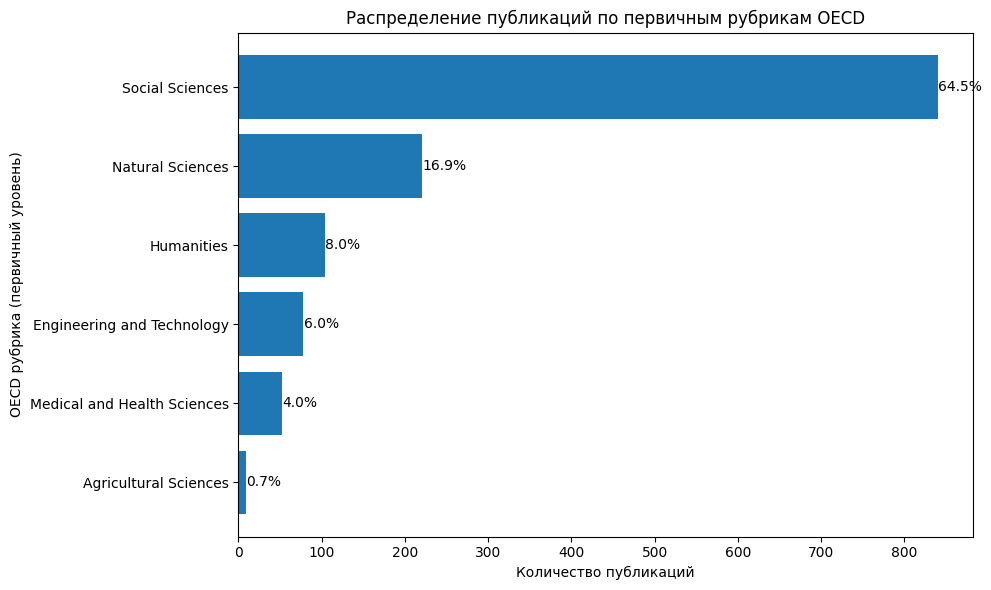

In [159]:
import matplotlib.pyplot as plt
# считаем категории, исключая "нет"
counts = (
    df['first_OECD']
    .value_counts()
    .loc[lambda s: s.index != 'нет']
    .sort_values(ascending=True)
)

total = counts.sum()  # общее количество для процентов

plt.figure(figsize=(10, 6))
bars = plt.barh(counts.index, counts.values)

# добавление процентов
for bar, value in zip(bars, counts.values):
    percent = value / total * 100
    plt.text(
        bar.get_width() + 0.5,   # чуть правее бара
        bar.get_y() + bar.get_height() / 2,
        f"{percent:.1f}%",       # формат: одна цифра после запятой
        va='center'
    )

plt.xlabel("Количество публикаций")
plt.ylabel("OECD рубрика (первичный уровень)")
plt.title("Распределение публикаций по первичным рубрикам OECD")

plt.tight_layout()
plt.show()


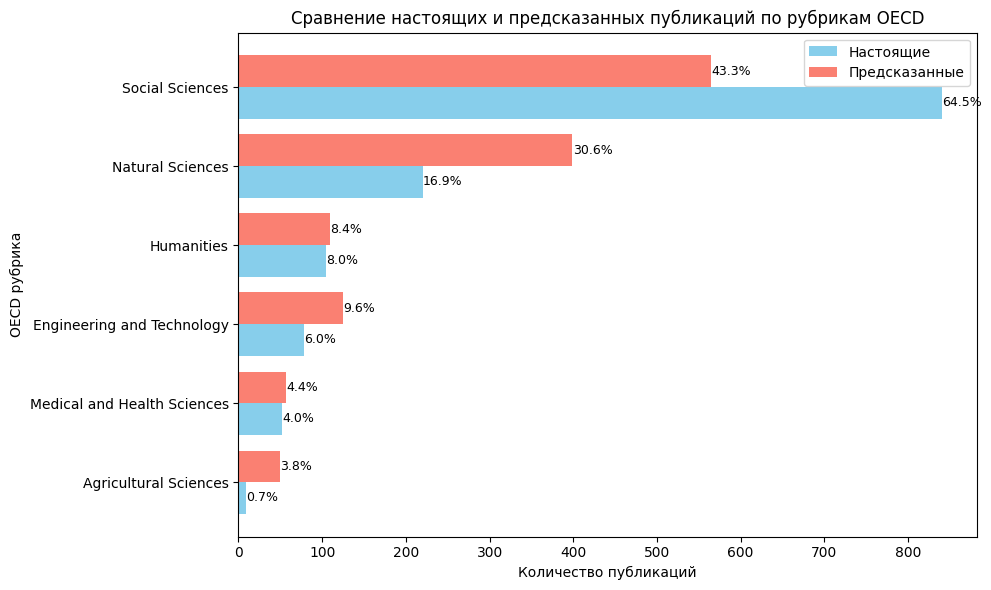

In [90]:
import matplotlib.pyplot as plt
import numpy as np
 
change_dict = {
    'Engineering': 'Engineering and Technology',
    'IT and Natural Sciences': 'Natural Sciences',
}

df['first_OECD_pred'] = df['first_OECD_pred'].replace(change_dict)

# фильтруем "нет"
true_counts = df['first_OECD'].value_counts().loc[lambda s: s.index != 'нет'].sort_values(ascending=True)
pred_counts = df['first_OECD_pred'].value_counts().loc[lambda s: s.index != 'нет'].reindex(true_counts.index, fill_value=0)

# позиции для горизонтальных баров
y_pos = np.arange(len(true_counts))
height = 0.4

plt.figure(figsize=(10, 6))

# настоящие публикации
plt.barh(y_pos - height/2, true_counts.values, height=height, color='skyblue', label='Настоящие')

# предсказанные публикации
plt.barh(y_pos + height/2, pred_counts.values, height=height, color='salmon', label='Предсказанные')

# подписи процентов для каждой серии
total_true = true_counts.sum()
total_pred = pred_counts.sum()

for i, (t, p) in enumerate(zip(true_counts.values, pred_counts.values)):
    plt.text(t + 0.5, i - height/2, f"{t/total_true*100:.1f}%", va='center', fontsize=9)
    plt.text(p + 0.5, i + height/2, f"{p/total_pred*100:.1f}%", va='center', fontsize=9)

plt.yticks(y_pos, true_counts.index)
plt.xlabel("Количество публикаций")
plt.ylabel("OECD рубрика")
plt.title("Сравнение настоящих и предсказанных публикаций по рубрикам OECD")
plt.legend()
plt.tight_layout()
plt.show()


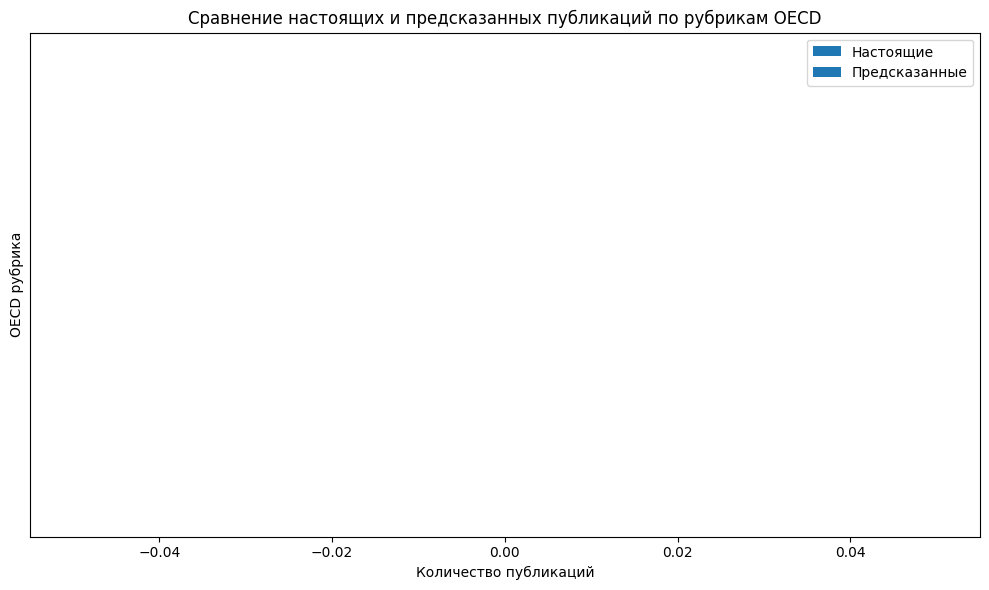

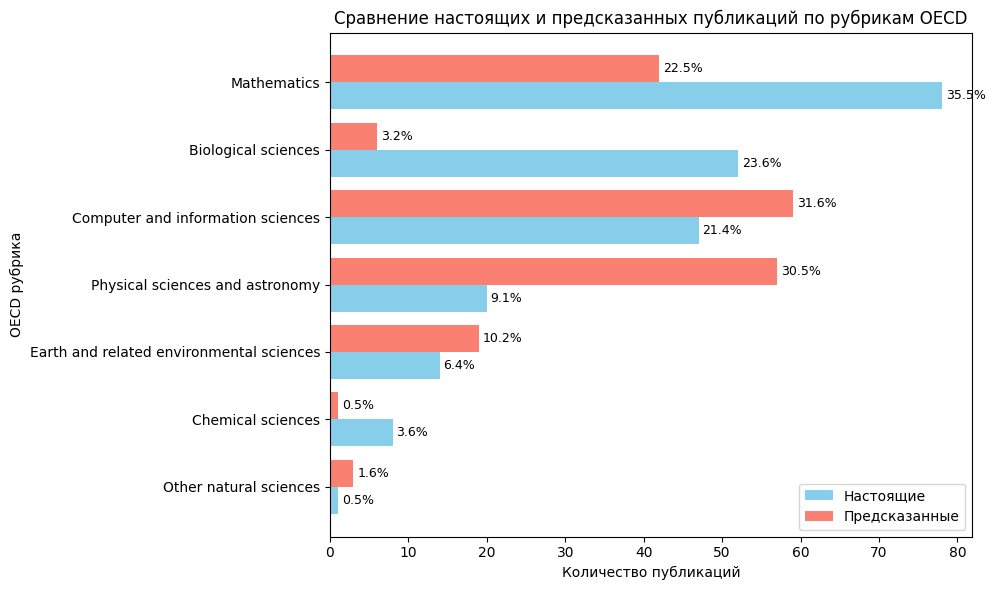

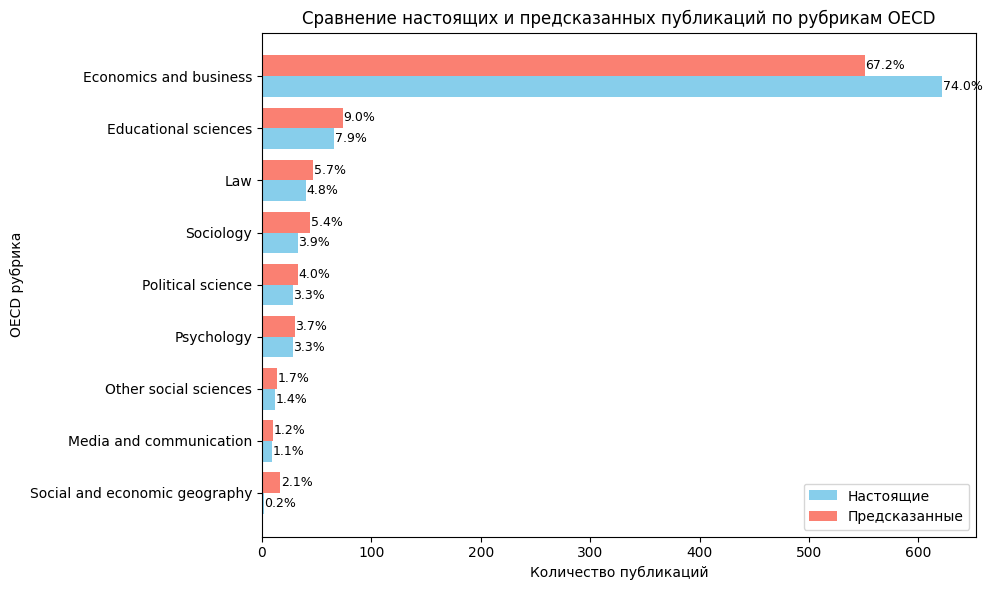

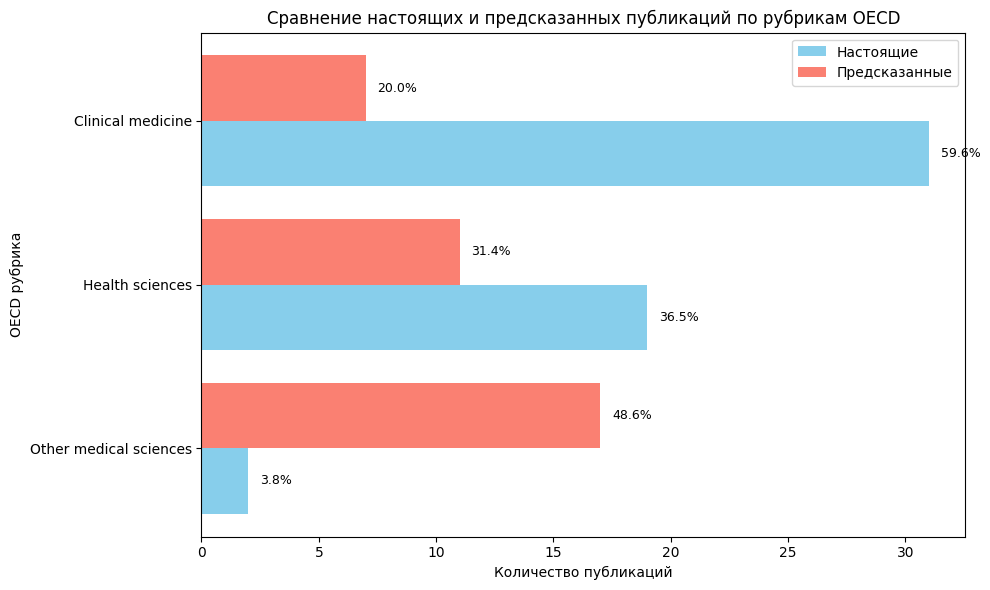

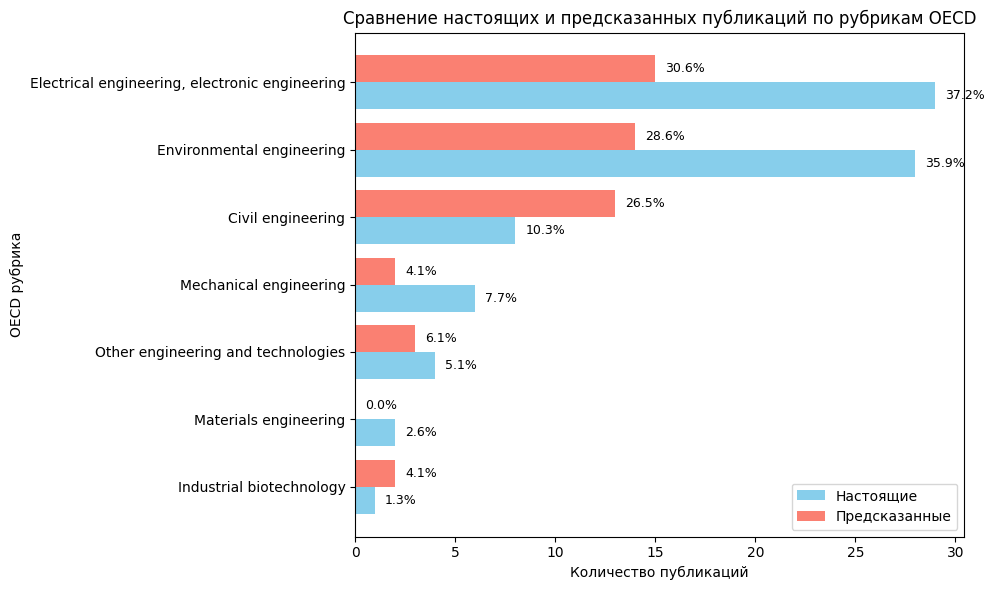

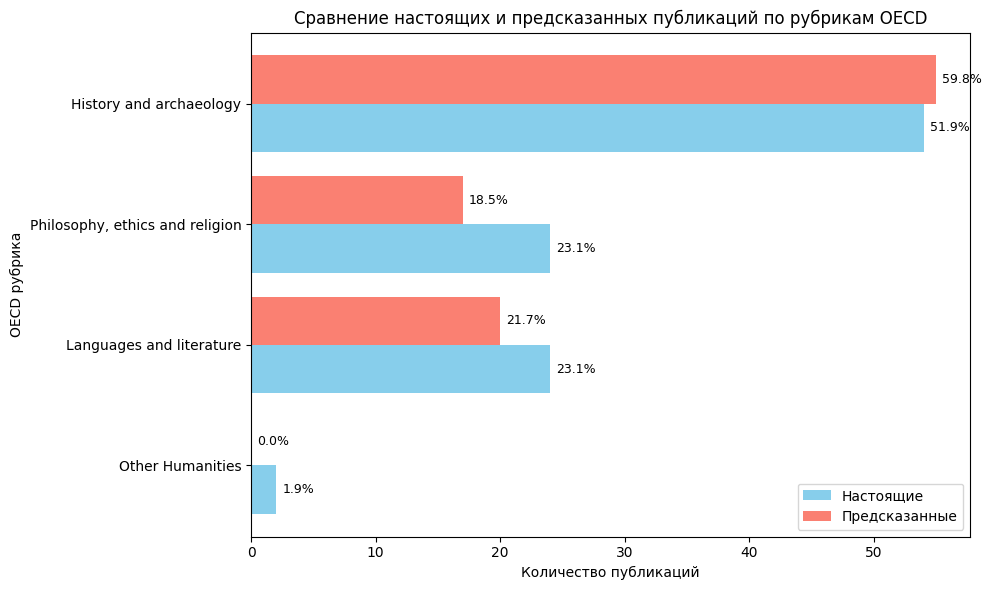

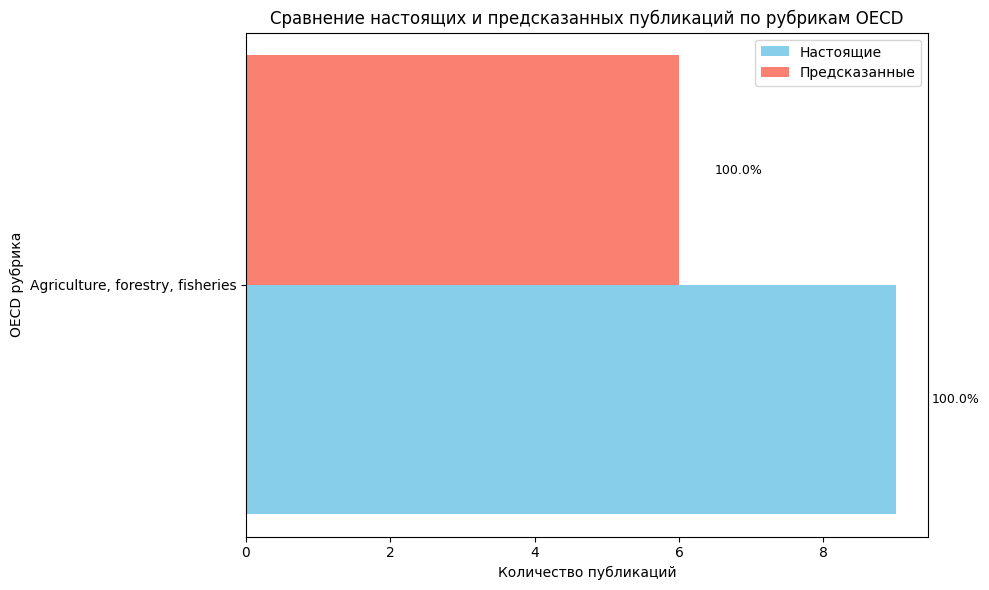

In [163]:
for label in df['first_OECD'].unique():
    # фильтруем "нет"
    df_label = df[df['first_OECD'] == label]
    true_counts = df_label['OECD'].value_counts().loc[lambda s: s.index != 'нет'].sort_values(ascending=True)
    pred_counts = df_label['OECD_pred'].value_counts().loc[lambda s: s.index != 'нет'].reindex(true_counts.index, fill_value=0)

    # позиции для горизонтальных баров
    y_pos = np.arange(len(true_counts))
    height = 0.4

    plt.figure(figsize=(10, 6))

    # настоящие публикации
    plt.barh(y_pos - height/2, true_counts.values, height=height, color='skyblue', label='Настоящие')

    # предсказанные публикации
    plt.barh(y_pos + height/2, pred_counts.values, height=height, color='salmon', label='Предсказанные')

    # подписи процентов для каждой серии
    total_true = true_counts.sum()
    total_pred = pred_counts.sum()

    for i, (t, p) in enumerate(zip(true_counts.values, pred_counts.values)):
        plt.text(t + 0.5, i - height/2, f"{t/total_true*100:.1f}%", va='center', fontsize=9)
        plt.text(p + 0.5, i + height/2, f"{p/total_pred*100:.1f}%", va='center', fontsize=9)

    plt.yticks(y_pos, true_counts.index)
    plt.xlabel("Количество публикаций")
    plt.ylabel("OECD рубрика")
    plt.title("Сравнение настоящих и предсказанных публикаций по рубрикам OECD")
    plt.legend()
    plt.tight_layout()
    plt.show()
